In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm

from qiskit import  BasicAer, Aer, execute, assemble, QuantumCircuit
from qiskit.quantum_info.operators import Operator
backend = Aer.get_backend("qasm_simulator")

from qiskit.visualization import plot_histogram

In [2]:
# QFT

def phase_rotate(circuit, n):  
    if n == 0: return circuit    
    n = n-1
    circuit.h(n)    
    for qubit in range(n): circuit.cp(np.pi/2**(n-qubit), qubit, n)     
    phase_rotate(circuit, n)

def swap_registers(circuit, n):    
    for qubit in range(n//2): circuit.swap(qubit, n-qubit-1)
        
def qft(circuit, n, where):
    qc = QuantumCircuit(n)
    phase_rotate(qc,n)
    swap_registers(qc,n)
    qft = qc.to_gate()
    qft.name = " QFT "
    circuit.append(qft, range(where,n+where))

def qft_dagger(circuit, n, where):
    qc = QuantumCircuit(n)
    phase_rotate(qc,n)
    swap_registers(qc,n)
    
    qc_dagger = qc.inverse()
    qft_dagger = qc_dagger.to_gate()
    qft_dagger.name = " QFT$^\dagger$ "
    circuit.append(qft_dagger, range(where,n+where))

#### Ex1

In [3]:
matrix = np.array([[1, -1/3], [-1/3, 1]])
vector = np.array([1, 0])

classic_solution = np.linalg.solve(matrix, vector)
norm = np.linalg.norm(classic_solution)
eigenvals,eigenvecs=np.linalg.eig(matrix)
print("sol:",classic_solution)
print("Eigenvalues:",eigenvals)
print("Eigenvectors:",eigenvecs)
print("Euclidean norm:",norm)

sol: [1.125 0.375]
Eigenvalues: [1.33333333 0.66666667]
Eigenvectors: [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
Euclidean norm: 1.1858541225631423


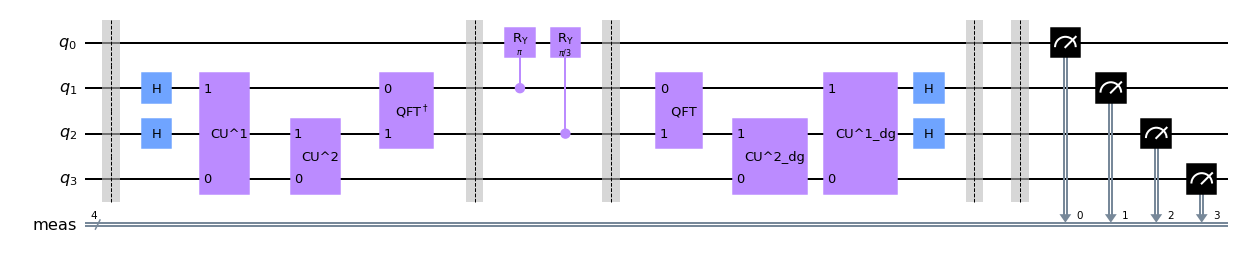

In [4]:
t = (3/4)*np.pi

def CU(A,num):
    qc = QuantumCircuit(2)
    U_A, C_U = np.eye(2, dtype='complex'), np.eye(4, dtype='complex')
    for i in range(num): U_A = U_A.dot(expm(1j*A*t))
    C_U[2:4,2:4] = U_A 

    qc.unitary(Operator(C_U), range(2))
    CU_gate = qc.to_gate()
    CU_gate.name = "CU^{}".format(num)
    return CU_gate

qc = QuantumCircuit(4)
# qc.x(3)

qc.barrier()

qc.h([1,2])
qc.append(CU(matrix,1),[3,1])
qc.append(CU(matrix,2),[3,2])


qft_dagger(qc,2,1)
qc.barrier()

qc.cry(np.pi,1,0)
qc.cry(np.pi/3,2,0)
qc.barrier()

qft(qc,2,1)
qc.append(CU(matrix,2).inverse(),[3,2])
qc.append(CU(matrix,1).inverse(),[3,1])
qc.h([1,2])

qc.save_statevector()
qc.measure_all()

qc.draw(output="mpl",fold=-1)

solution: [1.125 0.375]


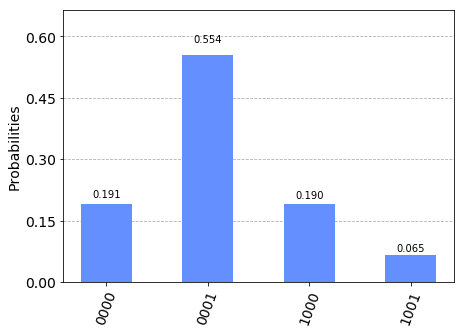

In [5]:
result = execute(qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[9]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

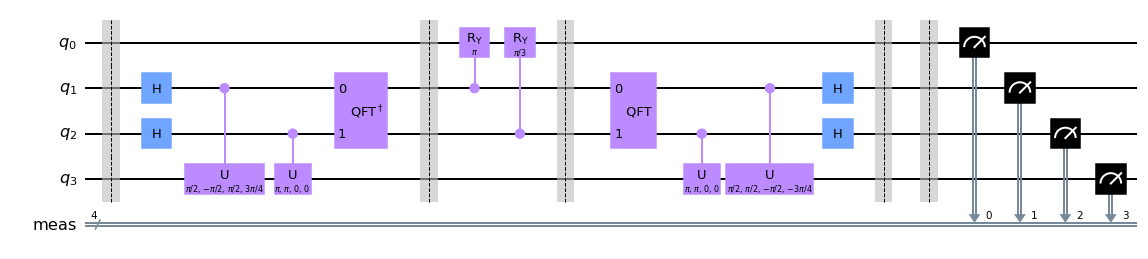

In [6]:
t = (3/4)*np.pi

from qiskit.circuit.library import CUGate
qc = QuantumCircuit(4)
# qc.x(3)

qc.barrier()

qc.h([1,2])
qc.append(CUGate(np.pi/2,-np.pi/2,np.pi/2,(3/4)*np.pi),[1,3])
qc.append(CUGate(np.pi,np.pi,0,0),[2,3])

qft_dagger(qc,2,1)
qc.barrier()


qc.cry(np.pi,1,0)
qc.cry(np.pi/3,2,0)
qc.barrier()

qft(qc,2,1)
qc.append(CUGate(np.pi,np.pi,0,0),[2,3])
qc.append(CUGate(np.pi/2,np.pi/2,-np.pi/2,(-3/4)*np.pi),[1,3])
qc.h([1,2])

qc.save_statevector()
qc.measure_all()

qc.draw(output="mpl",fold=-1)

solution: [1.125 0.375]


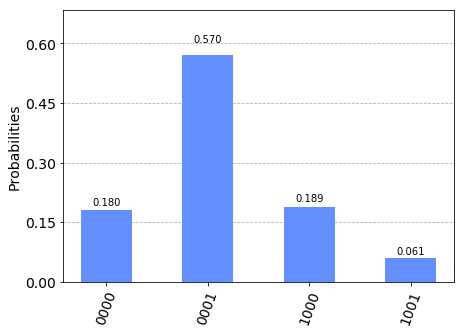

In [7]:
result = execute(qc, backend=backend, shots=4096, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[9]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

#### Qiskit built-in HHL algorithm

In [8]:
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector

hhl_solution = HHL().solve(matrix, vector)
print(hhl_solution.state.decompose().draw())
print('Euclidean norm:', hhl_solution.euclidean_norm)

sv = Statevector(hhl_solution.state).data
full_vector = np.real(np.array([sv[16], sv[17]]))
print('solution:', hhl_solution.euclidean_norm*full_vector/np.linalg.norm(full_vector))

       ┌──────────┐┌──────┐        ┌─────────┐
  q60: ┤ Isometry ├┤3     ├────────┤3        ├
       └──────────┘│      │┌──────┐│         │
q61_0: ────────────┤0     ├┤2     ├┤0        ├
                   │  QPE ││      ││  QPE_dg │
q61_1: ────────────┤1     ├┤1     ├┤1        ├
                   │      ││  1/x ││         │
q61_2: ────────────┤2     ├┤0     ├┤2        ├
                   └──────┘│      │└─────────┘
  q62: ────────────────────┤3     ├───────────
                           └──────┘           
Euclidean norm: 1.185854122563138
solution: [1.125 0.375]


#### Ex2

In [9]:
matrix = (1/4)*np.array([[15, 9, 5,-3],
                         [ 9,15, 3,-5],
                         [ 5, 3,15,-9],
                         [-3,-5,-9,15]])
vector = np.array([0, 0, 0, 1])

classic_solution = np.linalg.solve(matrix, vector)
norm = np.linalg.norm(classic_solution)
eigenvals,eigenvecs=np.linalg.eig(matrix)
print("sol:",classic_solution)
print("Eigenvalues:",eigenvals)
print("Eigenvectors:",eigenvecs)
print("Euclidean norm:",norm)

sol: [-0.09375  0.15625  0.28125  0.46875]
Eigenvalues: [8. 4. 1. 2.]
Eigenvectors: [[ 0.5  0.5  0.5  0.5]
 [ 0.5  0.5 -0.5 -0.5]
 [ 0.5 -0.5 -0.5  0.5]
 [-0.5  0.5 -0.5  0.5]]
Euclidean norm: 0.5762215285808054


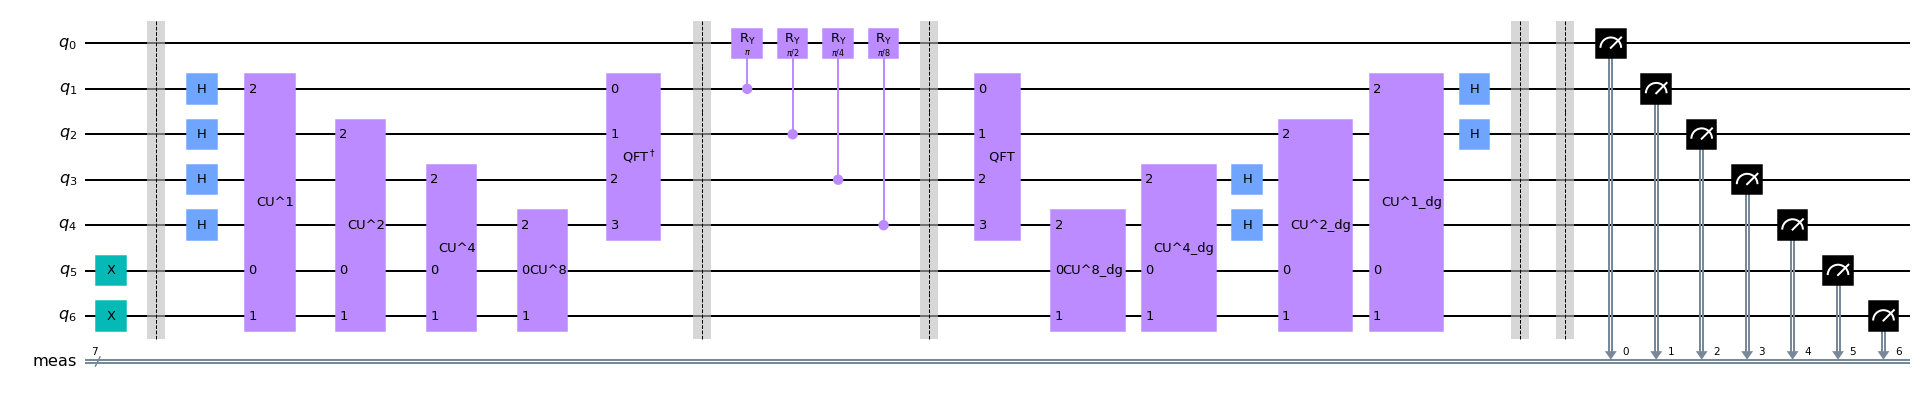

In [10]:
t = (1/8)*np.pi

def CU(A,num):
    qc = QuantumCircuit(3)
    U_A, C_U = np.eye(4, dtype='complex'), np.eye(8, dtype='complex')
    for i in range(num): U_A = U_A.dot(expm(1j*A*t))
    C_U[4:8,4:8] = U_A 

    qc.unitary(Operator(C_U), range(3))
    CU_gate = qc.to_gate()
    CU_gate.name = "CU^{}".format(num)
    return CU_gate

qc = QuantumCircuit(7)
qc.x([5,6])

qc.barrier()

qc.h([1,2,3,4])
rep = 1
for i in range(4):
    qc.append(CU(matrix,rep),[5,6,i+1])
    rep*=2
  
qft_dagger(qc,4,1)
qc.barrier()

qc.cry(np.pi,1,0)
qc.cry(np.pi/2,2,0)
qc.cry(np.pi/4,3,0)
qc.cry(np.pi/8,4,0)
qc.barrier()

qft(qc,4,1)
rep = 8
for i in range(4):
    qc.append(CU(matrix,int(rep)).inverse(),[5,6,4-i])
    rep/=2 
qc.h([1,2,3,4])

qc.save_statevector()
qc.measure_all()
# qc.measure([0,5,6],[0,1,2])

qc.draw(output="mpl",fold=-1)

solution: [-0.02337502  0.10666063  0.25069468  0.50720858]


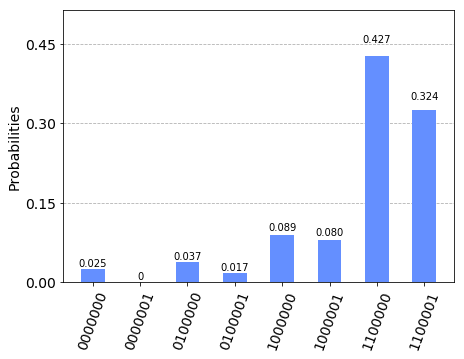

In [11]:
result = execute(qc, backend=backend, shots=4096*2, memory=True).result()
sv = result.get_statevector()
sol_vector = np.real(np.array([sv[1], sv[33], sv[65], sv[97]]))
print("solution:", norm*sol_vector/np.linalg.norm(sol_vector))

plot_histogram(result.get_counts())

#### Qiskit built-in HHL algorithm

In [12]:
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector

hhl_solution = HHL().solve(matrix, vector)
print(hhl_solution.state.decompose().draw())
print('Euclidean norm:', hhl_solution.euclidean_norm)

sv = Statevector(hhl_solution.state).data
full_vector = np.real(np.array([sv[128], sv[129], sv[130], sv[131]]))
print('solution:', hhl_solution.euclidean_norm*full_vector/np.linalg.norm(full_vector))

        ┌───────────┐┌──────┐        ┌─────────┐
q119_0: ┤0          ├┤5     ├────────┤5        ├
        │  Isometry ││      │        │         │
q119_1: ┤1          ├┤6     ├────────┤6        ├
        └───────────┘│      │┌──────┐│         │
q120_0: ─────────────┤0     ├┤4     ├┤0        ├
                     │      ││      ││         │
q120_1: ─────────────┤1 QPE ├┤3     ├┤1 QPE_dg ├
                     │      ││      ││         │
q120_2: ─────────────┤2     ├┤2     ├┤2        ├
                     │      ││  1/x ││         │
q120_3: ─────────────┤3     ├┤1     ├┤3        ├
                     │      ││      ││         │
q120_4: ─────────────┤4     ├┤0     ├┤4        ├
                     └──────┘│      │└─────────┘
  q121: ─────────────────────┤5     ├───────────
                             └──────┘           
Euclidean norm: 0.5762215285807775
solution: [-0.09375  0.15625  0.28125  0.46875]
